In [3]:
import pandas as pd

# Load the Excel file and read the "FMCG-Dataset" sheet
file_path = "Dataset-1 (1).xlsx"  # Update with your file's path
xls = pd.ExcelFile(file_path)
fmcg_dataset = xls.parse('FMCG-Dataset')


In [4]:
# Step 1: Clean the dataset
# Drop unnecessary columns and rename for clarity
fmcg_cleaned = fmcg_dataset.drop(columns=['Unnamed: 1'])  # Remove irrelevant column
fmcg_cleaned.columns = ['Period', 'Demand_2015', 'Demand_2016', 'Seasonal_Index']  # Rename columns

In [5]:
# Step 2: Handle missing value
# Manually set cell C27 (row 26, column 'Demand_2015') to NaN
fmcg_cleaned.loc[26, 'Demand_2015'] = None

In [6]:
# Replace NaN in 'Demand_2015' with the column's mean
mean_demand_2015 = fmcg_cleaned['Demand_2015'].mean()  # Calculate mean
fmcg_cleaned.loc[26, 'Demand_2015'] = mean_demand_2015  # Replace NaN with mean

In [7]:
# Step 3: Handle specified outliers
# Define the outlier rows (1-based indices adjusted for Python's 0-based indexing)
outlier_indices = [22, 44, 48]

In [8]:
# Calculate 5th and 95th percentiles for each relevant column
caps = {
    "Demand_2015": {
        "lower": fmcg_cleaned["Demand_2015"].quantile(0.05),
        "upper": fmcg_cleaned["Demand_2015"].quantile(0.95)
    },
    "Demand_2016": {
        "lower": fmcg_cleaned["Demand_2016"].quantile(0.05),
        "upper": fmcg_cleaned["Demand_2016"].quantile(0.95)
    },
    "Seasonal_Index": {
        "lower": fmcg_cleaned["Seasonal_Index"].quantile(0.05),
        "upper": fmcg_cleaned["Seasonal_Index"].quantile(0.95)
    }
}

In [9]:
# Cap the outliers in the specified rows only
for idx in outlier_indices:
    for col in ["Demand_2015", "Demand_2016", "Seasonal_Index"]:
        if fmcg_cleaned.at[idx, col] < caps[col]["lower"]:
            fmcg_cleaned.at[idx, col] = caps[col]["lower"]
        elif fmcg_cleaned.at[idx, col] > caps[col]["upper"]:
            fmcg_cleaned.at[idx, col] = caps[col]["upper"]

In [10]:
# Display the cleaned dataset for verification
fmcg_cleaned.head()

,Period,Demand_2015,Demand_2016,Seasonal_Index
0,1,686904.0,1720612.0,2.000779
1,2,1151192.0,879430.0,1.249362
2,3,1156396.0,2079588.0,1.864774
3,4,1401562.0,1484410.0,1.514121
4,5,1551566.0,1108224.0,1.063990


In [11]:
# Save the cleaned FMCG dataset to a local file
cleaned_file_path = "FMCG_Cleaned.xlsx"  # Adjust the path if needed
fmcg_cleaned.to_excel(cleaned_file_path, index=False)

print(f"Cleaned dataset saved as {cleaned_file_path}.")


Cleaned dataset saved as FMCG_Cleaned.xlsx.


In [15]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Convert 'Period' column to numeric, coercing errors to NaN
fmcg_cleaned['Period'] = pd.to_numeric(fmcg_cleaned['Period'], errors='coerce')

# Drop rows with NaN in 'Period' (if any invalid data remains)
fmcg_cleaned = fmcg_cleaned.dropna(subset=['Period'])

# Convert 'Period' to integer for further processing
fmcg_cleaned['Period'] = fmcg_cleaned['Period'].astype(int)

# Proceed with feature engineering
# Step 1: Add Time-Based Features
fmcg_cleaned['Year'] = fmcg_cleaned['Period'].apply(lambda x: 2015 if x <= 52 else 2016)
fmcg_cleaned['Week'] = fmcg_cleaned['Period'].apply(lambda x: x if x <= 52 else x - 52)
fmcg_cleaned['Quarter'] = fmcg_cleaned['Week'].apply(lambda x: (x - 1) // 13 + 1)
fmcg_cleaned['Is_Weekend'] = fmcg_cleaned['Week'] % 7 >= 5

# Step 2: Continue with other feature engineering steps...


# Step 2: Create Lag Features
fmcg_cleaned['Lag_1_Demand_2015'] = fmcg_cleaned['Demand_2015'].shift(1)
fmcg_cleaned['Lag_1_Demand_2016'] = fmcg_cleaned['Demand_2016'].shift(1)
fmcg_cleaned['Lag_2_Demand_2015'] = fmcg_cleaned['Demand_2015'].shift(2)
fmcg_cleaned['Lag_2_Demand_2016'] = fmcg_cleaned['Demand_2016'].shift(2)

# Handle missing values in lag features (first few rows will have NaN)
lag_columns = ['Lag_1_Demand_2015', 'Lag_1_Demand_2016', 'Lag_2_Demand_2015', 'Lag_2_Demand_2016']
fmcg_cleaned[lag_columns] = fmcg_cleaned[lag_columns].fillna(0)

# Step 3: Create Rolling Statistics
# Rolling mean (3-week window)
fmcg_cleaned['Rolling_Mean_3_Demand_2015'] = fmcg_cleaned['Demand_2015'].rolling(window=3).mean()
fmcg_cleaned['Rolling_Mean_3_Demand_2016'] = fmcg_cleaned['Demand_2016'].rolling(window=3).mean()
# Rolling standard deviation (5-week window)
fmcg_cleaned['Rolling_Std_5_Demand_2015'] = fmcg_cleaned['Demand_2015'].rolling(window=5).std()
fmcg_cleaned['Rolling_Std_5_Demand_2016'] = fmcg_cleaned['Demand_2016'].rolling(window=5).std()

# Handle missing values caused by rolling windows
rolling_columns = [
    'Rolling_Mean_3_Demand_2015', 'Rolling_Mean_3_Demand_2016',
    'Rolling_Std_5_Demand_2015', 'Rolling_Std_5_Demand_2016'
]
fmcg_cleaned[rolling_columns] = fmcg_cleaned[rolling_columns].fillna(0)

# Step 4: Scaling and Normalization
# Columns to scale
columns_to_scale = [
    'Demand_2015', 'Demand_2016', 'Seasonal_Index',
    'Lag_1_Demand_2015', 'Lag_1_Demand_2016',
    'Lag_2_Demand_2015', 'Lag_2_Demand_2016',
    'Rolling_Mean_3_Demand_2015', 'Rolling_Mean_3_Demand_2016',
    'Rolling_Std_5_Demand_2015', 'Rolling_Std_5_Demand_2016'
]

# Apply Min-Max Scaling
min_max_scaler = MinMaxScaler()
fmcg_cleaned_scaled = fmcg_cleaned.copy()
fmcg_cleaned_scaled[columns_to_scale] = min_max_scaler.fit_transform(fmcg_cleaned_scaled[columns_to_scale])

# Apply Standard Scaling
standard_scaler = StandardScaler()
fmcg_cleaned_standardized = fmcg_cleaned.copy()
fmcg_cleaned_standardized[columns_to_scale] = standard_scaler.fit_transform(fmcg_cleaned_standardized[columns_to_scale])

# Save the scaled and standardized datasets
scaled_file_path = "FMCG_Scaled.xlsx"
standardized_file_path = "FMCG_Standardized.xlsx"
fmcg_cleaned_scaled.to_excel(scaled_file_path, index=False)
fmcg_cleaned_standardized.to_excel(standardized_file_path, index=False)

print(f"Scaled dataset saved as {scaled_file_path}")
print(f"Standardized dataset saved as {standardized_file_path}")


Scaled dataset saved as FMCG_Scaled.xlsx
Standardized dataset saved as FMCG_Standardized.xlsx


Descriptive Statistics for 2015 Data:
Q1: 1111526.0
Median: 1332158.0
Q3: 1561527.5
Minimum: 686904.0
Maximum: 3037491.1999999993
Mean: 1455079.0322485208


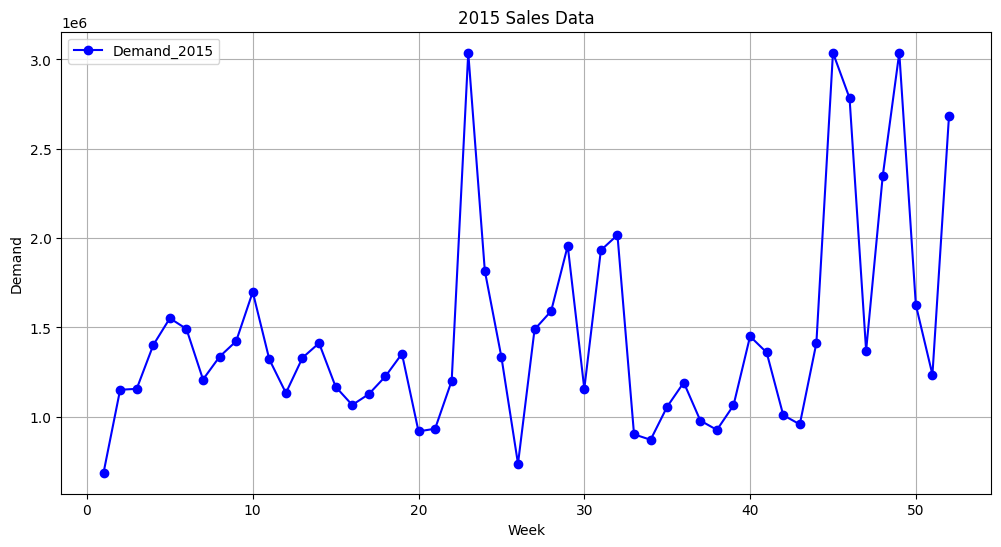

C:\Users\abdal\AppData\Local\Temp\ipykernel_12352\1667627239.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2015['Moving_Avg_Forecast'] = data_2015['Demand_2015'].rolling(window=window_size).mean()
C:\Users\abdal\AppData\Local\Temp\ipykernel_12352\1667627239.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2015['Moving_Avg_Forecast'] = data_2015['Moving_Avg_Forecast'].fillna(data_2015['Demand_2015'].iloc[0])


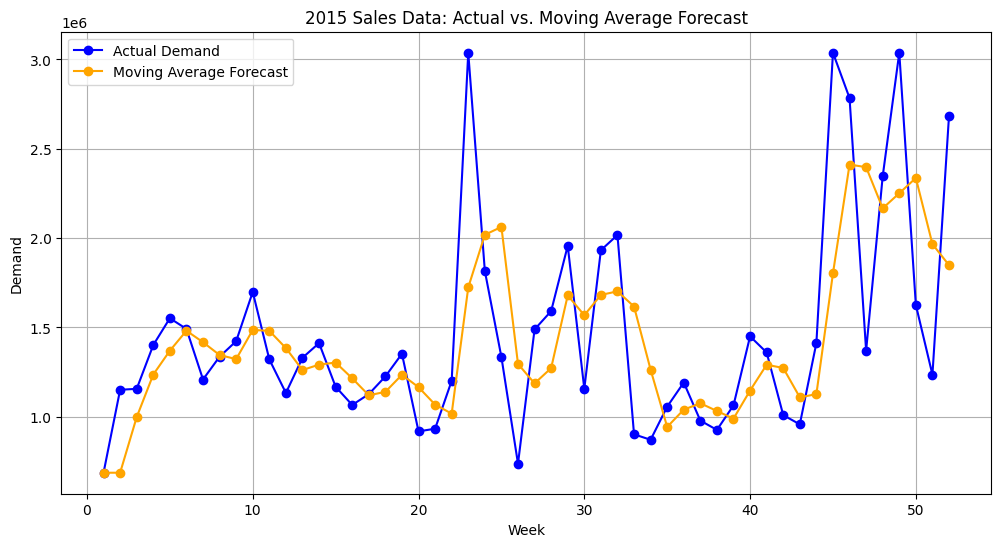

,Week,Demand_2015,Moving_Avg_Forecast
0,1,686904.0,6.869040e+05
1,2,1151192.0,6.869040e+05
2,3,1156396.0,9.981640e+05
3,4,1401562.0,1.236383e+06
4,5,1551566.0,1.369841e+06
5,6,1491678.0,1.481602e+06
6,7,1208586.0,1.417277e+06
7,8,1336380.0,1.345548e+06
8,9,1423160.0,1.322709e+06
9,10,1698638.0,1.486059e+06


In [16]:
import matplotlib.pyplot as plt

# Step 1: Extract 2015 data
data_2015 = fmcg_cleaned[fmcg_cleaned['Year'] == 2015]

# Step 2: Calculate Descriptive Statistics
descriptive_stats = data_2015['Demand_2015'].describe(percentiles=[0.25, 0.5, 0.75])

# Extract specific statistics
stats_summary = {
    "Q1": descriptive_stats['25%'],
    "Median": descriptive_stats['50%'],
    "Q3": descriptive_stats['75%'],
    "Minimum": descriptive_stats['min'],
    "Maximum": descriptive_stats['max'],
    "Mean": descriptive_stats['mean']
}

# Display the statistics
print("Descriptive Statistics for 2015 Data:")
for key, value in stats_summary.items():
    print(f"{key}: {value}")

# Step 3: Plot Actual Sales Data
plt.figure(figsize=(12, 6))
plt.plot(data_2015['Week'], data_2015['Demand_2015'], marker='o', label='Demand_2015', color='blue')
plt.title('2015 Sales Data')
plt.xlabel('Week')
plt.ylabel('Demand')
plt.legend()
plt.grid()
plt.show()

# Step 4: Implement Moving Average Forecast Model
# Define the window size for moving average
window_size = 3

# Calculate the moving average forecast
data_2015['Moving_Avg_Forecast'] = data_2015['Demand_2015'].rolling(window=window_size).mean()

# Fill initial NaN values with the first available demand value
data_2015['Moving_Avg_Forecast'] = data_2015['Moving_Avg_Forecast'].fillna(data_2015['Demand_2015'].iloc[0])

# Step 5: Plot Actual vs. Moving Average Forecast
plt.figure(figsize=(12, 6))
plt.plot(data_2015['Week'], data_2015['Demand_2015'], marker='o', label='Actual Demand', color='blue')
plt.plot(data_2015['Week'], data_2015['Moving_Avg_Forecast'], marker='o', label='Moving Average Forecast', color='orange')
plt.title('2015 Sales Data: Actual vs. Moving Average Forecast')
plt.xlabel('Week')
plt.ylabel('Demand')
plt.legend()
plt.grid()
plt.show()

# Display the first few rows of data with forecasts
data_2015[['Week', 'Demand_2015', 'Moving_Avg_Forecast']].head(10)


C:\Users\abdal\AppData\Roaming\Python\Python312\site-packages\pandas\util\_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
C:\Users\abdal\AppData\Local\Temp\ipykernel_12352\2816477118.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2015['Exp_Smoothing_Forecast'] = exp_smoothing_fit.fittedvalues


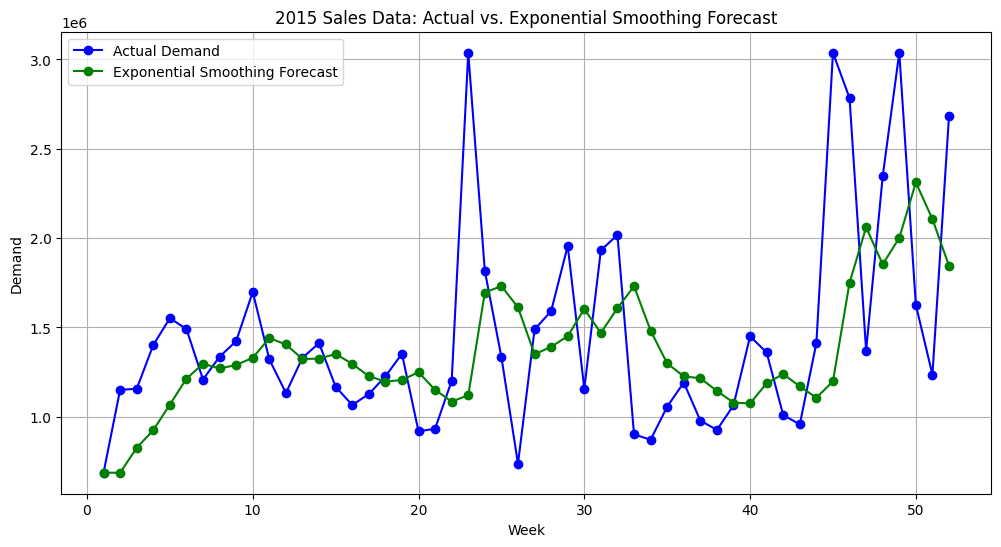

   Week  Demand_2015  Exp_Smoothing_Forecast
0     1     686904.0            6.869040e+05
1     2    1151192.0            6.869040e+05
2     3    1156396.0            8.261904e+05
3     4    1401562.0            9.252521e+05
4     5    1551566.0            1.068145e+06
5     6    1491678.0            1.213171e+06
6     7    1208586.0            1.296723e+06
7     8    1336380.0            1.270282e+06
8     9    1423160.0            1.290111e+06
9    10    1698638.0            1.330026e+06


In [17]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt

# Step 1: Implement Exponential Smoothing Model
# Define the smoothing level (alpha)
alpha = 0.3  # Adjust for tuning if needed

# Create and fit the exponential smoothing model
exp_smoothing_model = ExponentialSmoothing(
    data_2015['Demand_2015'],
    trend=None,  # No trend component
    seasonal=None,  # No seasonal component
    initialization_method="legacy-heuristic"
)

# Fit the model
exp_smoothing_fit = exp_smoothing_model.fit(smoothing_level=alpha)

# Generate fitted values (forecasts for the same data range)
data_2015['Exp_Smoothing_Forecast'] = exp_smoothing_fit.fittedvalues

# Step 2: Visualize Actual vs. Exponential Smoothing Forecast
plt.figure(figsize=(12, 6))
plt.plot(data_2015['Week'], data_2015['Demand_2015'], marker='o', label='Actual Demand', color='blue')
plt.plot(data_2015['Week'], data_2015['Exp_Smoothing_Forecast'], marker='o', label='Exponential Smoothing Forecast', color='green')
plt.title('2015 Sales Data: Actual vs. Exponential Smoothing Forecast')
plt.xlabel('Week')
plt.ylabel('Demand')
plt.legend()
plt.grid()
plt.show()

# Display the first few rows of data with forecasts
print(data_2015[['Week', 'Demand_2015', 'Exp_Smoothing_Forecast']].head(10))


In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Calculate Error Metrics for Moving Average Model
mae_moving_avg = mean_absolute_error(data_2015['Demand_2015'], data_2015['Moving_Avg_Forecast'])
mse_moving_avg = mean_squared_error(data_2015['Demand_2015'], data_2015['Moving_Avg_Forecast'])
rmse_moving_avg = np.sqrt(mse_moving_avg)

# Step 2: Calculate Error Metrics for Exponential Smoothing Model
mae_exp_smoothing = mean_absolute_error(data_2015['Demand_2015'], data_2015['Exp_Smoothing_Forecast'])
mse_exp_smoothing = mean_squared_error(data_2015['Demand_2015'], data_2015['Exp_Smoothing_Forecast'])
rmse_exp_smoothing = np.sqrt(mse_exp_smoothing)

# Step 3: Compare Models
evaluation_results = {
    "Model": ["Moving Average", "Exponential Smoothing"],
    "MAE": [mae_moving_avg, mae_exp_smoothing],
    "MSE": [mse_moving_avg, mse_exp_smoothing],
    "RMSE": [rmse_moving_avg, rmse_exp_smoothing]
}

# Convert evaluation results to DataFrame
evaluation_results_df = pd.DataFrame(evaluation_results)

# Display the results
print(evaluation_results_df)


                   Model            MAE           MSE           RMSE
0         Moving Average  316342.717949  1.922613e+11  438476.132246
1  Exponential Smoothing  403356.381725  3.209334e+11  566509.882892


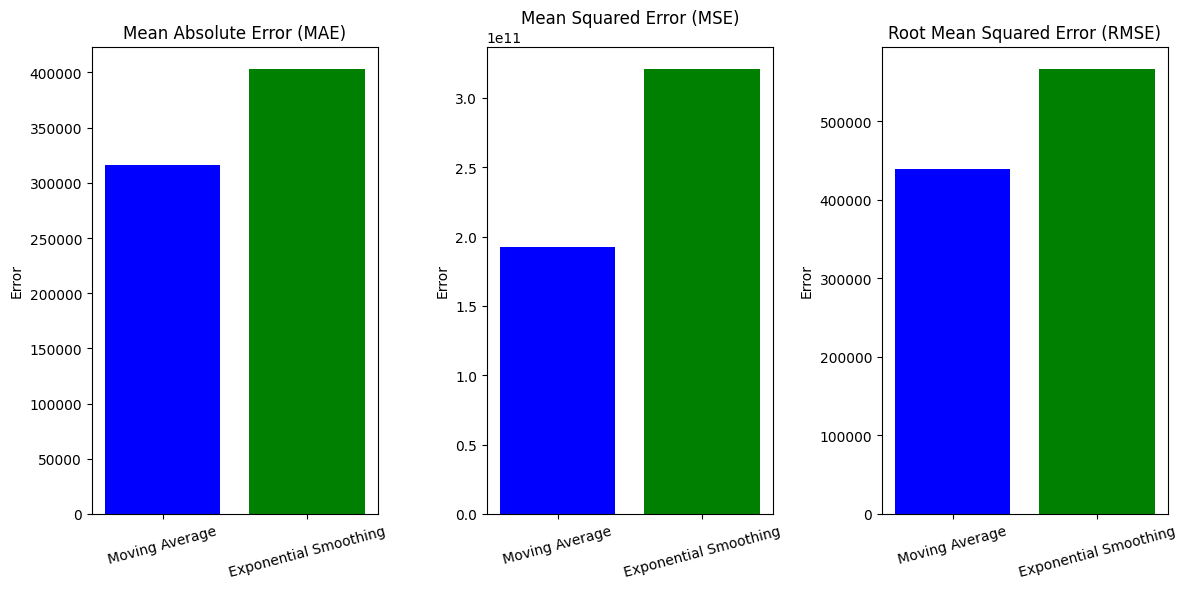

In [19]:
# Step 4: Visualize Model Comparison
plt.figure(figsize=(12, 6))

# Bar plot for MAE
plt.subplot(1, 3, 1)
plt.bar(evaluation_results_df['Model'], evaluation_results_df['MAE'], color=['blue', 'green'])
plt.title('Mean Absolute Error (MAE)')
plt.ylabel('Error')
plt.xticks(rotation=15)

# Bar plot for MSE
plt.subplot(1, 3, 2)
plt.bar(evaluation_results_df['Model'], evaluation_results_df['MSE'], color=['blue', 'green'])
plt.title('Mean Squared Error (MSE)')
plt.ylabel('Error')
plt.xticks(rotation=15)

# Bar plot for RMSE
plt.subplot(1, 3, 3)
plt.bar(evaluation_results_df['Model'], evaluation_results_df['RMSE'], color=['blue', 'green'])
plt.title('Root Mean Squared Error (RMSE)')
plt.ylabel('Error')
plt.xticks(rotation=15)

plt.tight_layout()
plt.show()
